#### HEAT EQUATION 2D
Let $\Omega = (-1 , 1)^2$, $\alpha \in \mathbb{R}$, $T> 0$ and $f \in L^2([0,T]\times\Omega), g \in H^{1/2}(\Omega)$:

$$
    \begin{cases}
        \begin{array}{rl}
            \partial_t u - \alpha \Delta u + f &= 0  \text{ in } \Omega, t \in [0,T],\\
            u(0, x) &= g(x) \text{ in } \Omega.
        \end{array}
    \end{cases}
$$

#### PDE DATA
Let $\omega > 0$, $\lambda = 2 \pi \omega$, $\Lambda_0 = \Lambda_0(t,x) = \lambda(x+t)$ and $\Lambda_1 = \Lambda_1(t,y) = \lambda(y+t)$:

$$
    \begin{split}
        u(t, x, y) &= \cos(\Lambda_0(t, x, y)) \sin(\Lambda_1(t, x, y)),\\
        g(x,y) &=  u(0, x, y),\\
        f(t, x, y) &= \lambda(\cos(\Lambda_0)\cos(\Lambda_1)-\sin(\Lambda_0)\sin(\Lambda_1))-2\alpha\lambda^2u.
    \end{split}
$$


#### EXPERIMENTS:
Experiment 1: $T=3$, $\alpha=10^{-4}$, $\lambda = 2 \pi \omega$, $\omega=0.3$, $p=2$;

Experiment 2: $T=10^{-4}$, $\alpha=0.5$, $\lambda = 2 \pi \omega$, $\omega=1.0$, $p=2$;

In [1]:
import numpy as np
import sys
import json
sys.path.insert(1, 'C:/Users/philh/Notebooks/thesis_framework/')
from differentiation import Differentiation
from cubature import Cubature
from benchmark import Benchmark
from utilities import matmul, data_axes, leg_bary, laplacian, inverse_lu, mui_lp_ext,\
cart, hyper_rect, pullback

#### CUBATURE AND DIFFERENTIATION

In [2]:
# DOMAIN #
deg_d = [5, 10, 10]
cuba_d = Cubature(deg_d)
w_d = cuba_d.leja_weights
xs_d = cuba_d.leja_axes
xs_plt_d = cuba_d.axes
bary = cuba_d.leja_axes_bary
diff = Differentiation(xs_d, bary)

# BOUNDARY #
deg_b = deg_d[1:3]
cuba_b = Cubature(deg_b)
w_b = cuba_b.leja_weights
xs_b = cuba_b.leja_axes
xs_plt_b = cuba_b.axes

#### LAPLACIAN OPERATORS

In [3]:
I = np.eye(len(w_d))
n_d = np.max(deg_d)

W_d = np.diag(w_d)
W_d_inv = np.linalg.inv(W_d)

M_1, M_1_inv = laplacian(diff.nabla, [W_d_inv]*3 , [W_d]*3)
M_1_s, _ = laplacian(diff.nabla, [W_d_inv]*3, [W_d]*3, weak=True)

M_1_mod = (M_1 + I/n_d**2)
M_1_s_mod = n_d*M_1_s

W_b = np.diag(w_b)

In [4]:
# ABSOLUTE ERROR OF OPERATOR NORM #
print(abs(np.linalg.norm(M_1)-1.0))
print(abs(np.linalg.norm(M_1_s)-1.0))

0.4754944037166844
0.3480028667150161


#### PULLBACK

In [5]:
time = 1e-4
phi, dphi = hyper_rect(np.array([[0.0, time], [-1.0, 1.0], [-1.0, 1.0]]))
diff.nabla = pullback(diff.nabla, dphi, cuba_d.leja_grid)
dt, dx, dy = diff.nabla
dx2, dy2 = diff.diffs(np.array([[0,2,0], [0,0,2]]))

#### PDE DATA

In [6]:
alpha = 0.5
omega = 0.1
lam = 2*np.pi*omega

def gt(t,x,y):
    t, x, y = phi([t, x, y])
    return np.cos(lam*(x+t))*np.sin(lam*(y+t))

def f(t,x,y):
    t, x, y = phi([t, x, y])
    return -lam*(np.cos(lam*(x+t))*np.cos(lam*(y+t))-np.sin(lam*(x+t))*np.sin(lam*(y+t)))-\
            2*alpha*lam**2*gt(t,x,y)

#### $l^p$ DEGREE AND BENCHMARK INITIALIZATION

In [7]:
# l^p #
p = 2
mui = mui_lp_ext(deg_d, p)

# BENCHMARK #
time_plt = np.linspace(-1.0, 1.0, 10)
test_xs = [np.linspace(-1.0, 1.0, 20), *[np.linspace(-1.0, 1.0, 50)]*2]
data = data_axes(test_xs, mui).T
bm = Benchmark(gt, test_xs, data)
eval_gt = bm.eval_gt()

print(f'L^2 norm gt1: {np.mean(np.array(eval_gt[0])**2)**0.5}')
print(f'L^inf norm gt1: {np.max(abs(np.array(eval_gt[0])))}')

L^2 norm gt1: 0.3320138791658865
L^inf norm gt1: 0.587788228823513


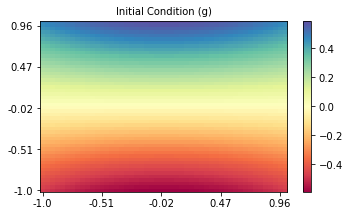

Ground Truth:


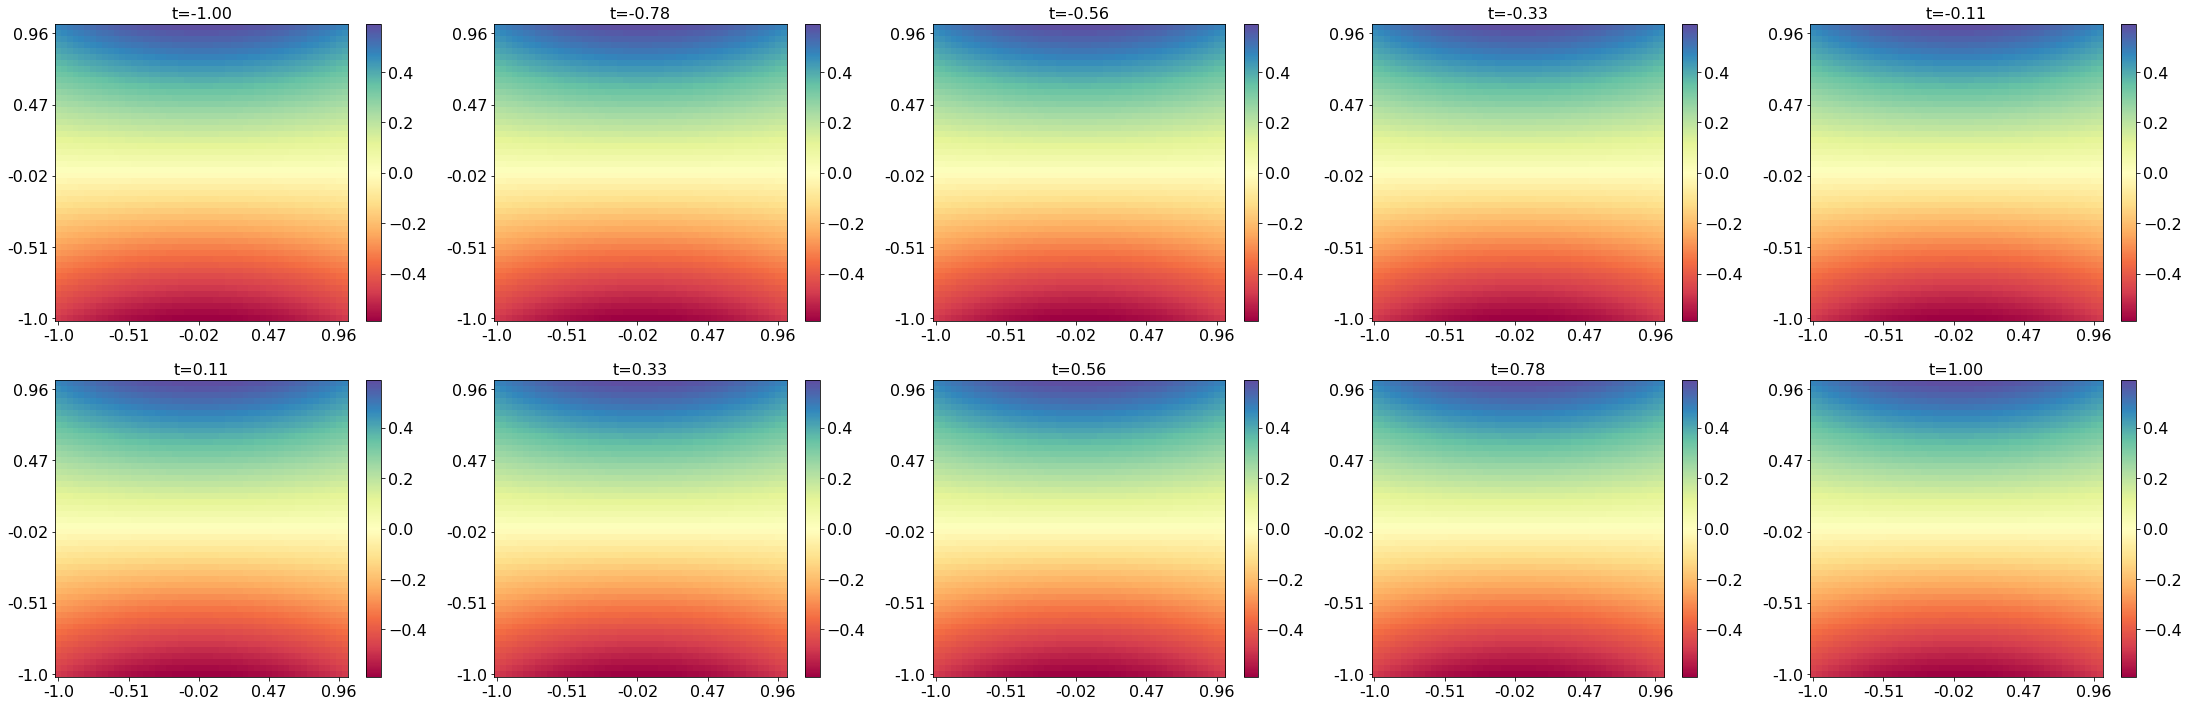

In [8]:
fn_g = None#f'{prefix}_pde_data_g'
fn_gt = None#f'{prefix}_pde_data_gt'

g_plt = gt(-1, *np.meshgrid(test_xs[1], test_xs[2]))
gt_plt = [gt(t, *np.meshgrid(test_xs[1], test_xs[2])) for t in time_plt]

bm.plot2d(g_plt, test_xs[1], test_xs[2],title="Initial Condition (g)", file_name=fn_g)
print("Ground Truth:")
bm.plot3d(gt_plt,time_plt,test_xs[1], test_xs[2], file_name=fn_gt)

#### PDE DATA RESOLUTION

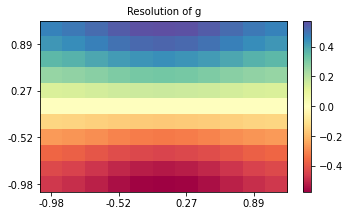

Resolution of Ground Truth:


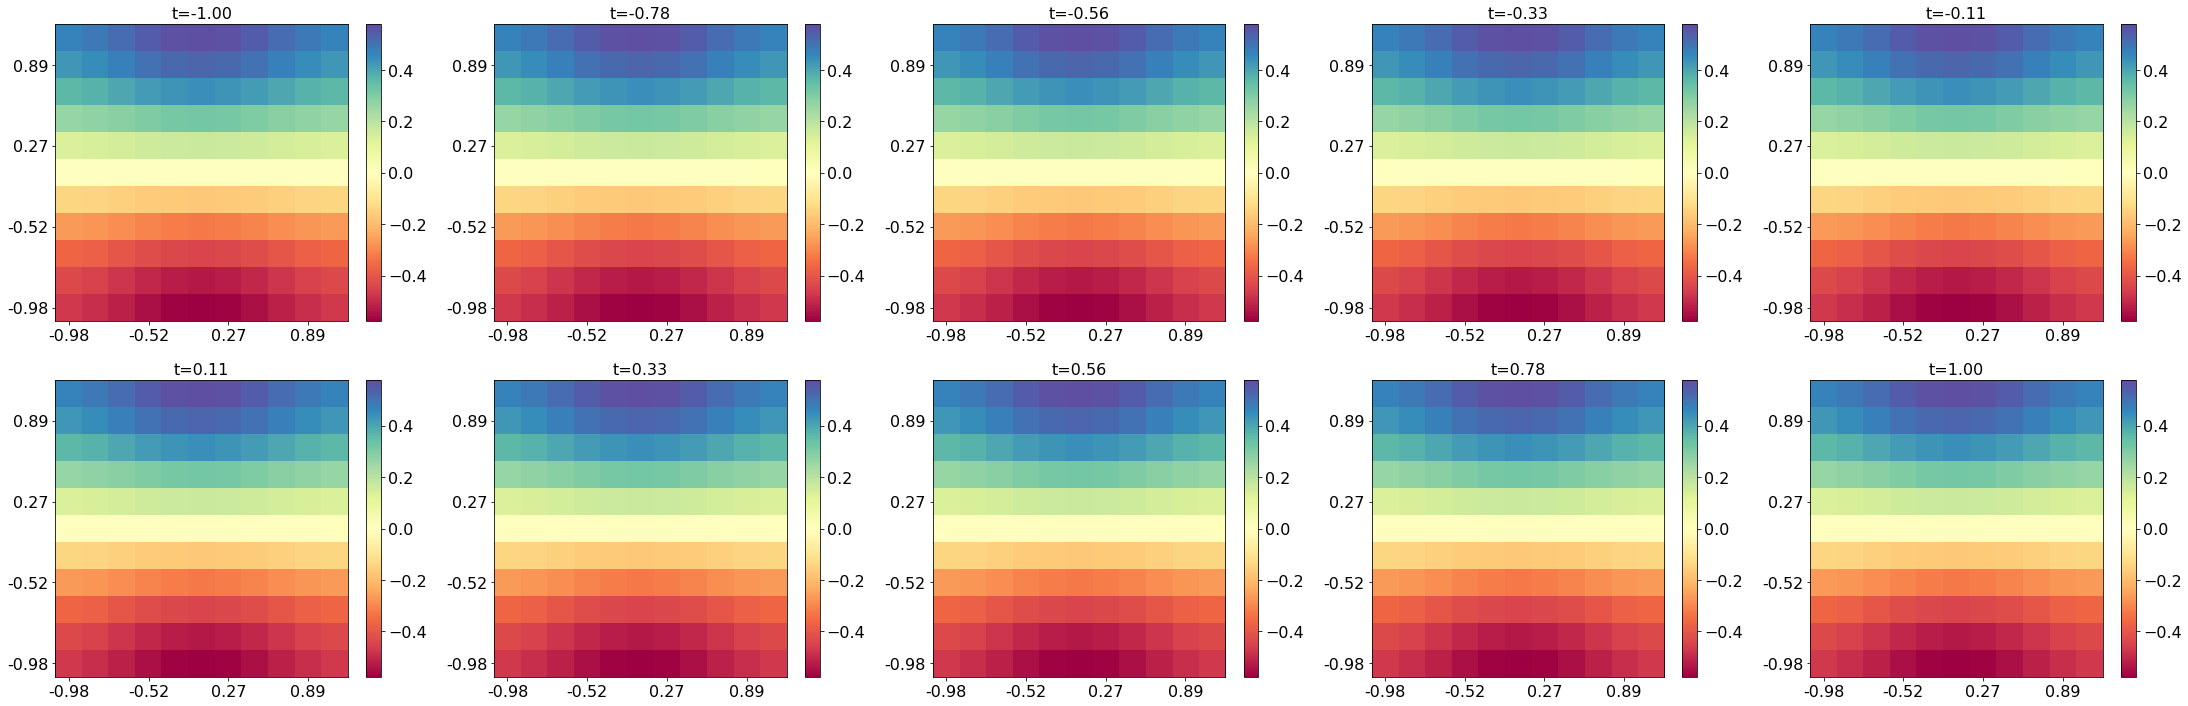

In [9]:
x_plt_b = cuba_b.grid[:,0]
y_plt_b = cuba_b.grid[:,1]
shape_plt = [len(xs_plt_b[1]), len(xs_plt_b[0])]

fn_g_res = None#f'{prefix}_pde_data_res_g'
fn_gt_res = None#f'{prefix}_pde_data_res_gt'

g_plt_res = gt(-1*np.ones_like(x_plt_b), x_plt_b, y_plt_b).reshape(*shape_plt)
gt_plt_res = [gt(t, *np.meshgrid(xs_plt_d[1], xs_plt_d[2])) for t in time_plt]

bm.plot2d(g_plt_res, xs_plt_b[0], xs_plt_b[1], title="Resolution of g", file_name=fn_g_res)
print("Resolution of Ground Truth:")
bm.plot3d(gt_plt_res, time_plt, xs_plt_d[1], xs_plt_d[2], file_name=fn_gt_res)

#### REGRESSION UTILITIES

In [10]:
grid_d = cuba_d.leja_grid
crnrs = np.array([-1.0])

C_d = data_axes(xs_d, mui).T

b_prot = [crnrs, *xs_b]
C_b = data_axes(b_prot, mui).T
    
grid_b = cart(b_prot)

gt_b = gt(
    grid_b[:,0], grid_b[:,1], grid_b[:,2] 
)

fTXY = f(grid_d[:,0], grid_d[:,1], grid_d[:,2])

#### DUAL LSQ FORMULATION

In [11]:
def metric(m): return lambda x: matmul(m,x)*x
T=dt-alpha*(dx2+dy2)
L = lambda u_d, u_b, metric, lam=1.0:\
    sum(w_d*metric(matmul(T, u_d)+fTXY))+lam*sum(matmul(W_b,(u_b-gt_b)**2))

#### TRUNCATION ERROR

In [12]:
gt_d = gt(grid_d[:,0], grid_d[:,1], grid_d[:,2])

arg = [gt_d, gt_b]
trunc_err = {
    "L_l2"   : L(*arg, metric(I)),
    "L_"     : L(*arg, metric(M_1), 1),
    "L_s"    : L(*arg, metric(M_1_s), 1),
    "L_mod"  : L(*arg, metric(M_1_mod), n_d),
    "L_s_mod": L(*arg, metric(M_1_s_mod), n_d)}
print(f'Truncation Errors:\n{json.dumps(trunc_err, indent=5)}')

Truncation Errors:
{
     "L_l2": 3.2254056034313496e-10,
     "L_": 9.032526409240321e-11,
     "L_s": 1.1086674080768312e-11,
     "L_mod": 9.355066969583452e-11,
     "L_s_mod": 1.1086674080768318e-10
}


#### SOLUTION

In [13]:
def solution(m1, m2, lam=1.0):
    E = matmul(C_d.T, W_d, m2, C_d)
    TC_d = matmul(T, C_d)
    TC_d_s = matmul(E, TC_d.T, W_d, m1)
    C_b_s = matmul(E, matmul(lam*W_b, C_b).T)
    T_sT_inv = inverse_lu(matmul(TC_d_s, TC_d)+matmul(C_b_s, C_b))
    T_sf = matmul(TC_d_s, -fTXY)+matmul(C_b_s, gt_b)
    theta = matmul(T_sT_inv, T_sf)
    theta = theta.reshape(len(theta),-1)
    return lambda X: np.matmul(np.array(X), theta)

In [14]:
cheb_l2 = solution(I, I)

cheb_ = solution(M_1, M_1_inv, lam=1)
cheb_s = solution(M_1_s, M_1_inv, lam=1)

cheb_mod = solution(M_1_mod, M_1_inv, lam=n_d)
cheb_s_mod = solution(M_1_s_mod, M_1_inv, lam=n_d)

# SET MODELS #
bm.set_model([cheb_l2, cheb_, cheb_s, cheb_mod, cheb_s_mod])

#### MODEL EVALUATION AND PLOT

In [15]:
_ = bm.eval_model()

Model plot:


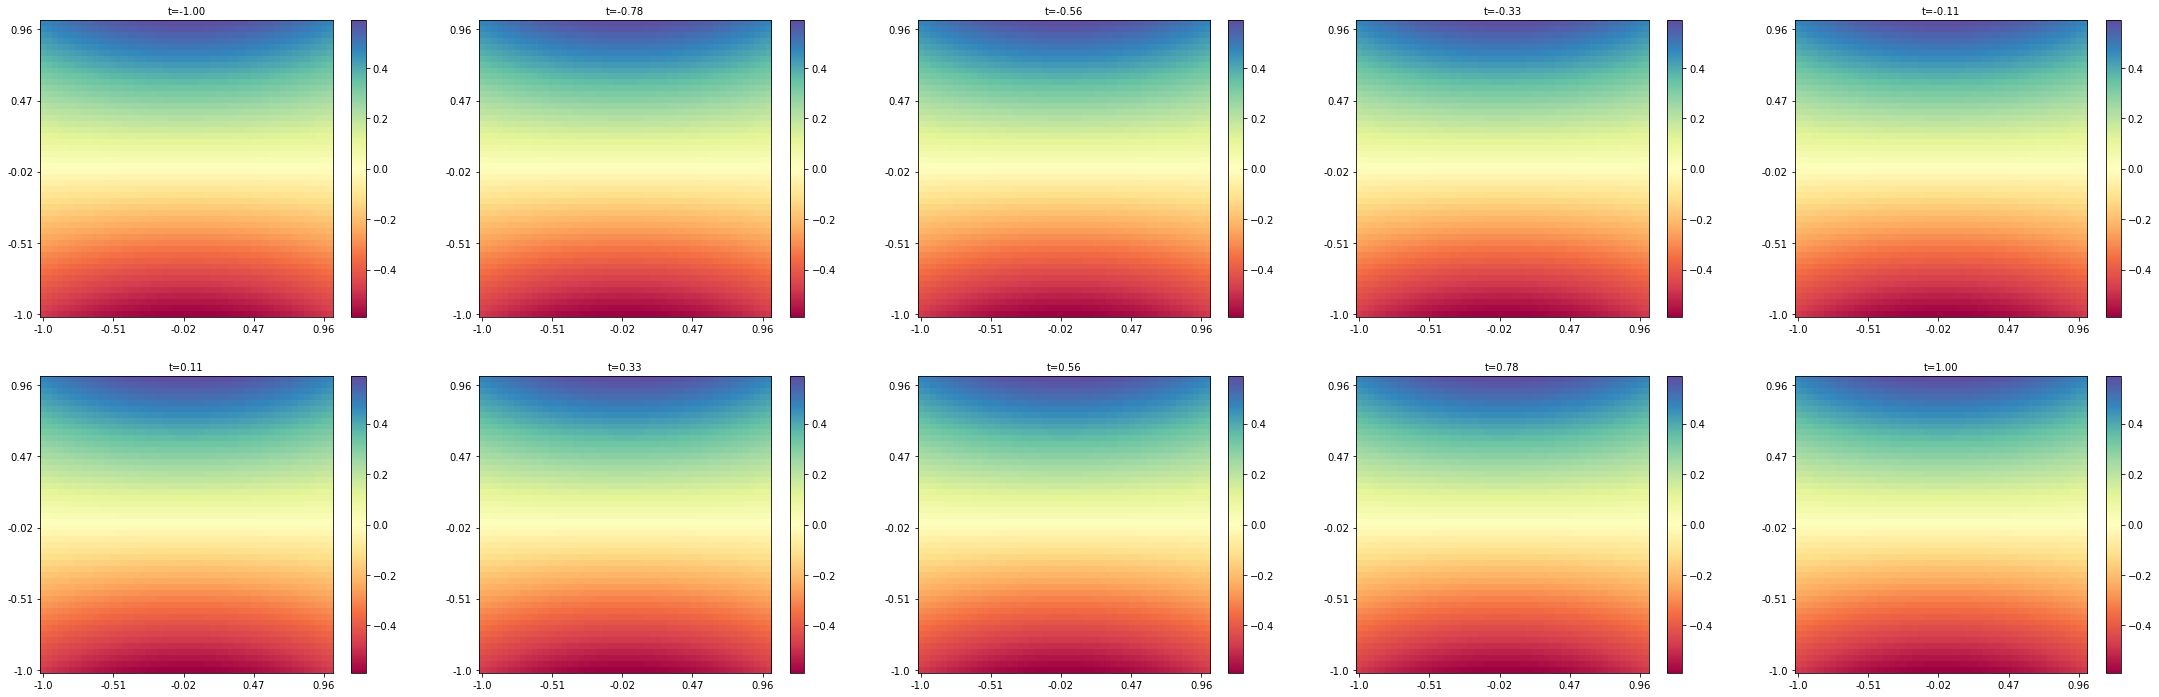

In [16]:
time_plt = np.linspace(-1.0, 1.0, 10)
# set model which should be plotted
model = cheb_s_mod

model_plt = [
    model(data_axes(
        [[t], test_xs[1], test_xs[2]], mui).T).T[0].reshape(
        len(test_xs[1]),
        len(test_xs[2])
    ) for t in time_plt]
print("Model plot:")
bm.plot3d(
    model_plt,
    time_plt,
    test_xs[1], test_xs[2],
    font_size=10,
    file_name=None)

#### ERROR

In [17]:
print(f'L1  Error: \n {bm.lp_err(1, precision=3)}')
print(f'L2  Error: \n {bm.lp_err(2, precision=3)}')
print(f'Max Error: \n {bm.lp_err(np.inf, precision=3)}')

L1  Error: 
 ['5.054e-10', '6.845e-07', '6.760e-10', '4.527e-09', '2.983e-09']
L2  Error: 
 ['1.541e-09', '7.18e-07', '7.721e-10', '4.548e-09', '3.091e-09']
Max Error: 
 ['3.974e-08', '1.167e-06', '1.592e-09', '5.696e-09', '4.388e-09']


#### TABLE FORMAT ERROR

In [18]:
err=np.array(
    [bm.lp_err(2, precision=2),
     bm.lp_err(np.inf, precision=2)])

row = f'{deg_d[1]} '
for _ in err.T:
    row = row + f'& {_[0]} & {_[1]} '
row = row + f'\\\\'

print(row)

10 & 1.54e-09 & 3.97e-08 & 7.18e-07 & 1.17e-06 & 7.72e-10 & 1.59e-09 & 4.55e-09 & 5.7e-09 & 3.09e-09 & 4.39e-09 \\
